In [1]:
import numpy as np
import sys
sys.path.append('../Codebase_AGWittmann/code-base/beamtime/')
import beamtime_utils as butils
import skimage
import os
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import curve_fit

In [2]:
basefolder = 'C:\\Users\\jskolaut\\Seafile\\My Library\\Beamtime_2310_MAXIV_Hematite\\Analysis\\'
basefolder = '/home/julisko/Seafile/My Library/Beamtime_2310_MAXIV_Hematite/Analysis/energy_images_dricorr/'
basefolderfiles = sorted(os.listdir(basefolder))

filenames = []
fileformats = []
tiffilenames = []

for i in range(len(basefolderfiles)):
    file = basefolderfiles[i]
    filenames.append(os.path.splitext(file)[0])
    fileformats.append(os.path.splitext(file)[1])
    if fileformats[i] == '.tif' or fileformats[i] == '.tiff':
        tiffilenames.append(filenames[i]+fileformats[i])
print(tiffilenames)

['Dn10_709p5_avg_dricorr.tif', 'Dn10_710p8_avg_dricorr.tif', 'Dn20_709p5_avg_dricorr.tif', 'Dn20_710p8_avg_dricorr.tif', 'Dn30_709p5_avg_dricorr.tif', 'Dn30_710p8_avg_dricorr.tif', 'Dn40_709p5_avg_dricorr.tif', 'Dn40_710p8_avg_dricorr.tif', 'Dn50_709p5_avg_dricorr.tif', 'Dn50_710p8_avg_dricorr.tif', 'Dn60_709p5_avg_dricorr.tif', 'Dn60_710p8_avg_dricorr.tif', 'Dn70_709p5_avg_dricorr.tif', 'Dn70_710p8_avg_dricorr.tif', 'Dn80_709p5_avg_dricorr.tif', 'Dn80_710p8_avg_dricorr.tif', 'Dp00_709p5_avg_dricorr.tif', 'Dp00_710p8_avg_dricorr.tif', 'Dp10_709p5_avg_dricorr.tif', 'Dp10_710p8_avg_dricorr.tif', 'Dp20_709p5_avg_dricorr.tif', 'Dp20_710p8_avg_dricorr.tif', 'Dp30_709p5_avg_dricorr.tif', 'Dp30_710p8_avg_dricorr.tif', 'Dp40_709p5_avg_dricorr.tif', 'Dp40_710p8_avg_dricorr.tif', 'Dp50_709p5_avg_dricorr.tif', 'Dp50_710p8_avg_dricorr.tif', 'Dp60_709p5_avg_dricorr.tif', 'Dp60_710p8_avg_dricorr.tif', 'Dp70_709p5_avg_dricorr.tif', 'Dp70_710p8_avg_dricorr.tif', 'Dp80_709p5_avg_dricorr.tif', 'Dp80_710

In [34]:
cut_edgepx_i = 180
cut_edgepx_j = 180

nrangles = int(len(tiffilenames)/2)
imageshape= np.shape(butils.read_tiff(basefolder+tiffilenames[0]))
print(imageshape)
imagepxnr_i = imageshape[0]-2*cut_edgepx_i
imagepxnr_j = imageshape[1]-2*cut_edgepx_j
xmld_stack = np.zeros((nrangles, imagepxnr_i, imagepxnr_j))
xmld_stack_corrected = np.zeros_like(xmld_stack)


for i in range(nrangles):
    lo_energy_im = butils.read_tiff(basefolder+tiffilenames[2*i])[cut_edgepx_i:-1*cut_edgepx_i,cut_edgepx_j:-1*cut_edgepx_j]
    hi_energy_im = butils.read_tiff(basefolder+tiffilenames[2*i+1])[cut_edgepx_i:-1*cut_edgepx_i,cut_edgepx_j:-1*cut_edgepx_j]
    #xmld_stack[i] = butils.get_xmld(lo_energy_im,hi_energy_im)   
    #xmld_stack[i] = lo_energy_im-hi_energy_im #/(lo_energy_im+hi_energy_im)
    xmld_stack[i] = lo_energy_im/hi_energy_im
    #xmld_stack_corrected[i] = butils.readjust_contrast(xmld_stack_corrected[i])
    xmld_stack_corrected[i] = butils.remove_polynomial_background(xmld_stack[i],n=1,small_size=imagepxnr_i)
    xmld_stack_corrected[i] = butils.readjust_contrast(xmld_stack_corrected[i])
    
print(np.shape(xmld_stack))

angles = np.zeros(nrangles)
for i in range(nrangles):
    if filenames[2*i][1] == 'n':
        angles[i] = -1 * int(filenames[2*i][2:4])
    if filenames[2*i][1] == 'p':
        angles[i] = int(filenames[2*i][2:4])

angles[0:8] = np.flip(angles[0:8])
xmld_stack_corrected[0:8,:,:] = np.flip(xmld_stack_corrected[0:8,:,:],axis=0)

resize = (128,128)
ang_fit, ang_fit_err, amp_fit, img_pixavg = butils.get_vector_map(xmld_stack_corrected,angles,resize=resize)

print('Done')


(1024, 1024)
(18, 664, 664)
Done


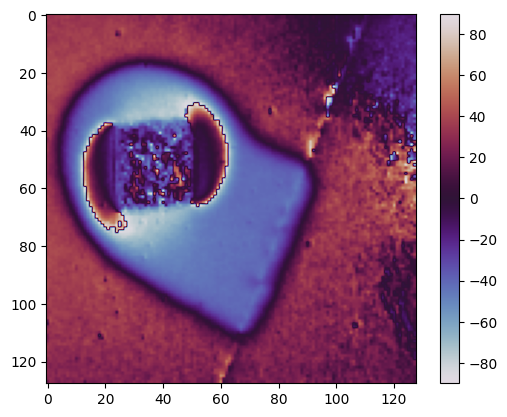

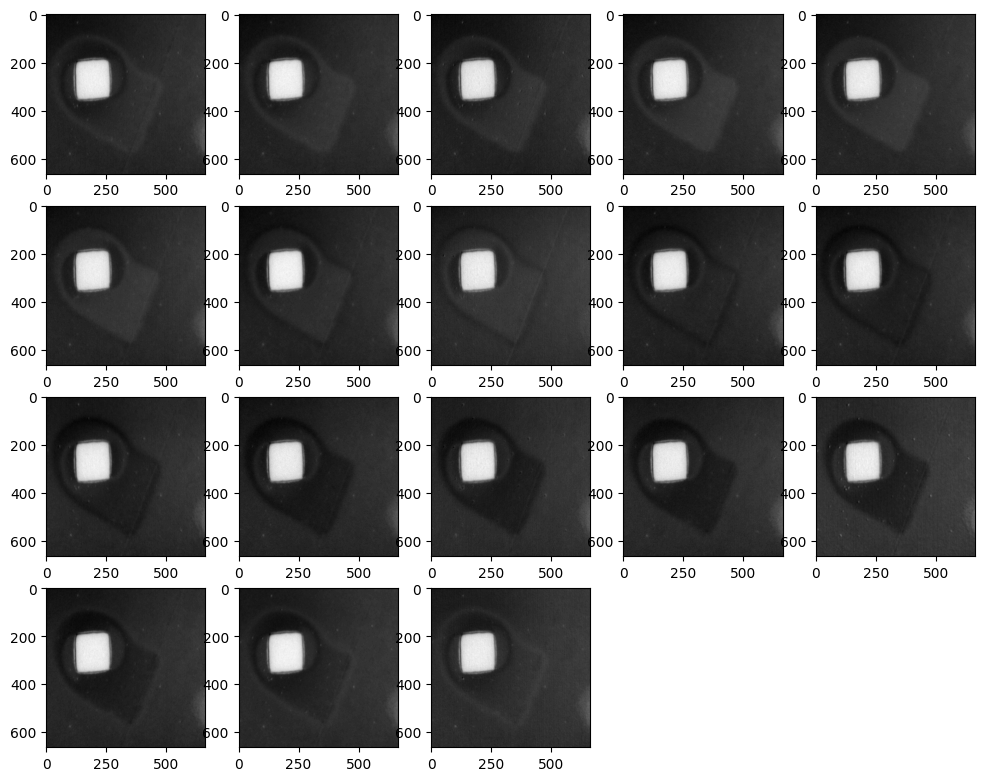

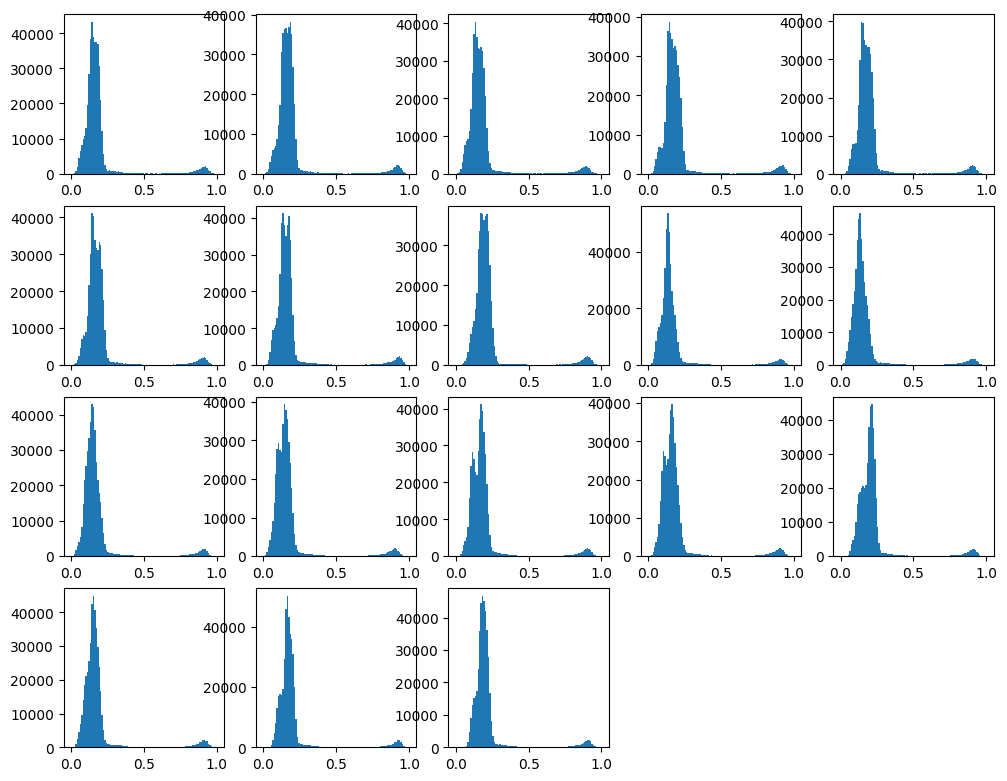

In [32]:
cm = 'twilight'

fig, ax = plt.subplots()
im = ax.imshow(ang_fit, cmap=cm, vmin=-90, vmax=90)
fig.colorbar(im)


fig = plt.figure(figsize=(12,12))
for i in range(nrangles):
    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
    ax_temp.imshow(xmld_stack_corrected[i],cmap='gray', vmin = 0, vmax = 1)

fig = plt.figure(figsize=(12,12))
for i in range(nrangles):
    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
    ax_temp.hist(xmld_stack_corrected[i].ravel(), bins = 100)

#fig = plt.figure(figsize=(12,12))
#for i in range(nrangles):
#    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
#    ax_temp.imshow(xmld_stack[i],cmap='gray')#,vmax = 5)

#fig = plt.figure(figsize=(12,12))
#for i in range(nrangles):
#    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrangles))),int(np.ceil(np.sqrt(nrangles))),i+1)
#    ax_temp.hist(xmld_stack[i].ravel(), bins = 100)

35.43389543649139 0.06388176813365871 0.02745535626301194
34.403590829960585 0.05719227202263633 0.03601812937860851
32.97003888396835 0.05897961176654085 0.042747819058064976
38.58870102278817 0.055477201148567114 0.055769001267018364
38.599535187155254 0.05056258032108195 0.06445673162384798
40.678808899659785 0.047923720175516084 0.06764460572540988
39.098502516338684 0.04603537666574082 0.0732186381411919
29.424229086509428 0.06043151993615386 0.07171200712766342
-2.166587223003771 0.07090014987514008 0.06783786003743347
-26.81222920423809 0.0910084086549442 0.06418426221267819
-32.07906818861318 0.08900712042650137 0.10355207899199377
-43.43127068108792 0.09594918675883574 0.06600781768197657
-66.11846730480292 0.05860439441429371 0.08792854190239592
65.74302162427023 0.031003838432570256 0.10862212067649535
46.32873278733698 0.044152398663777986 0.10043888773440154
33.00212245082325 0.048707396753072084 0.10747573466376267
35.683856042497844 0.04765619205642827 0.1064002838817274

/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_2205/2107286182.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig0,ax0 = plt.subplots()


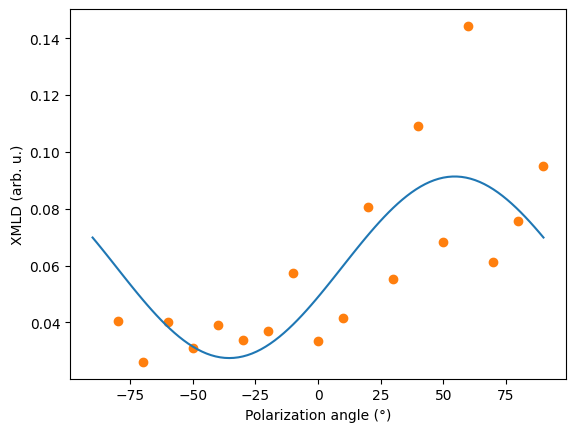

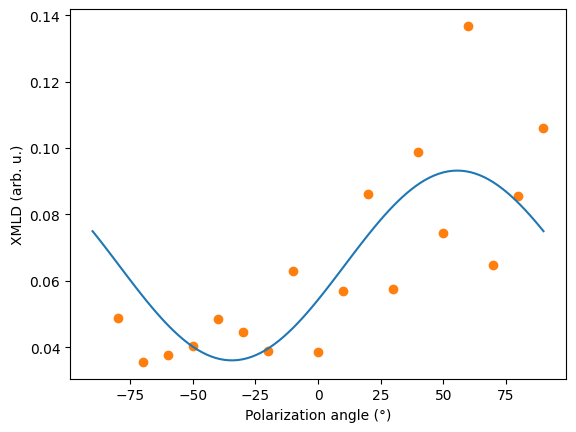

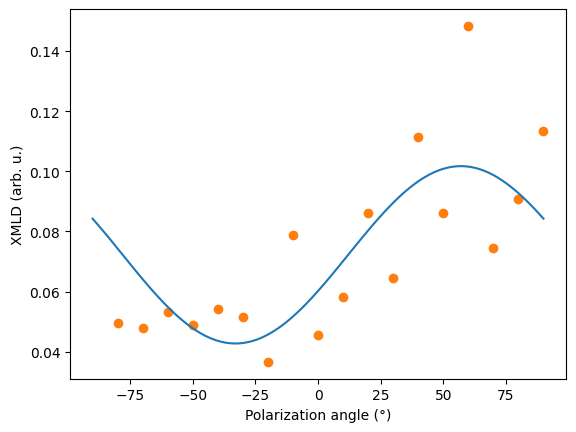

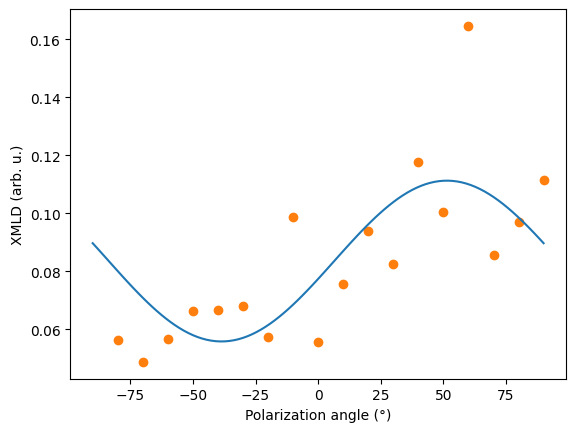

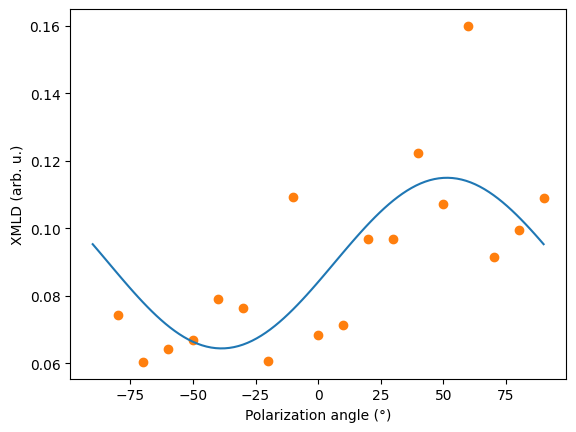

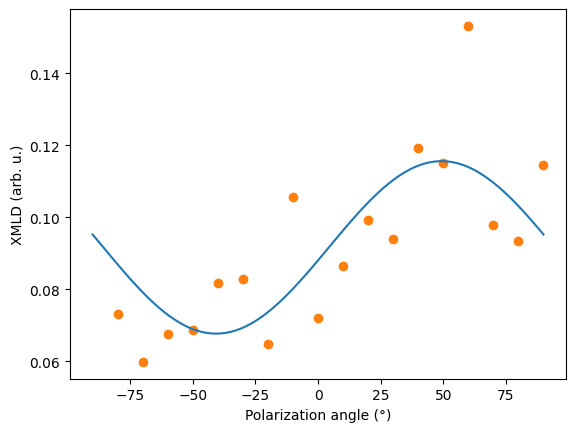

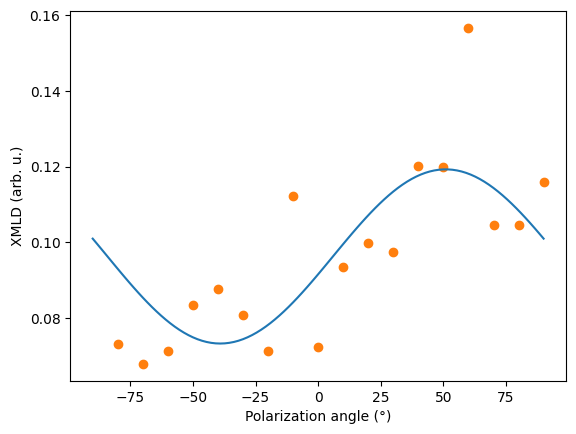

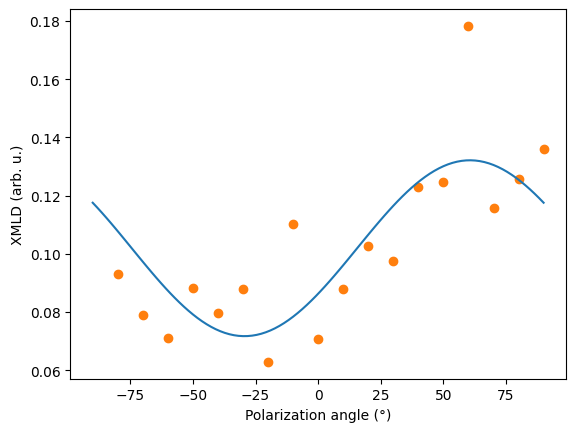

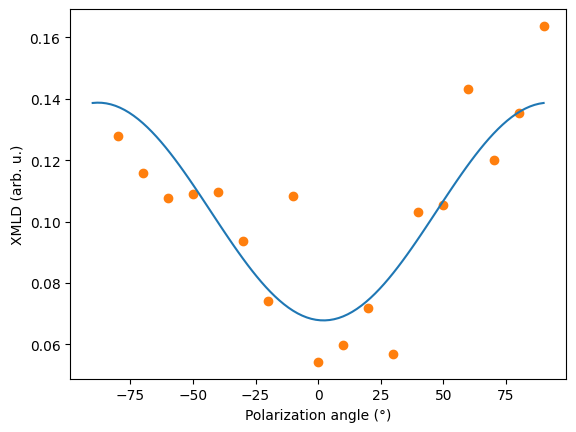

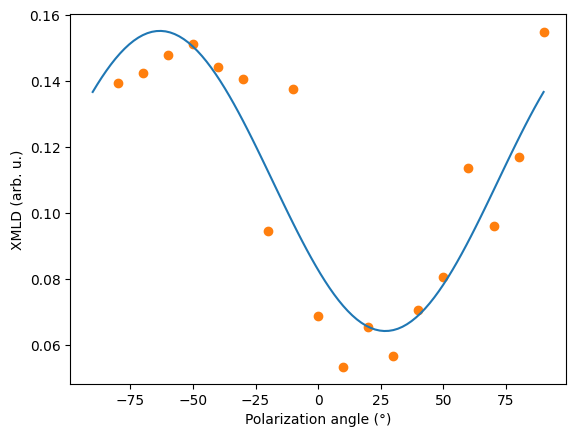

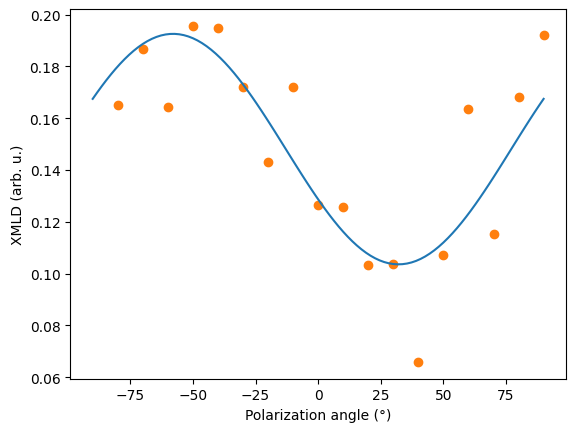

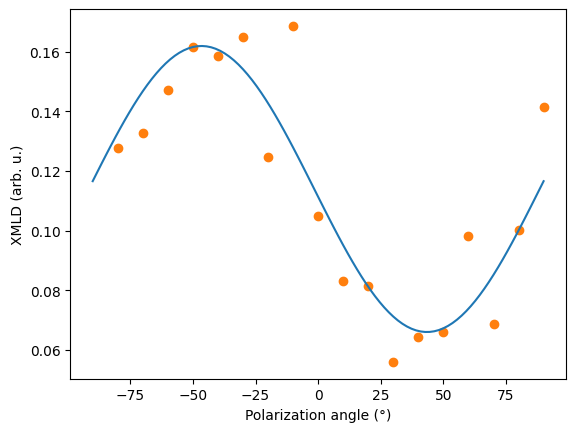

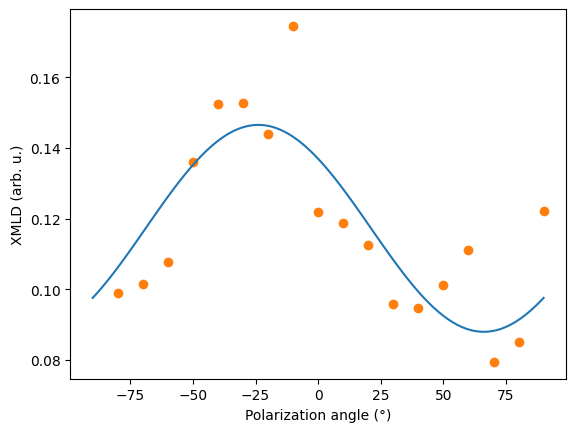

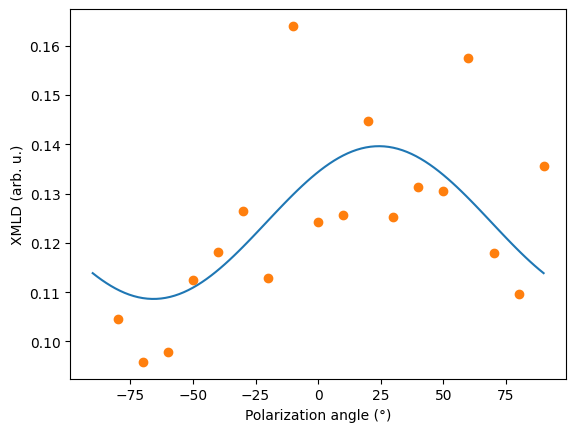

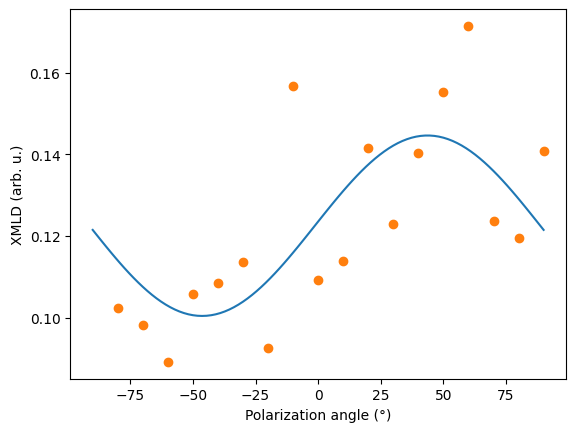

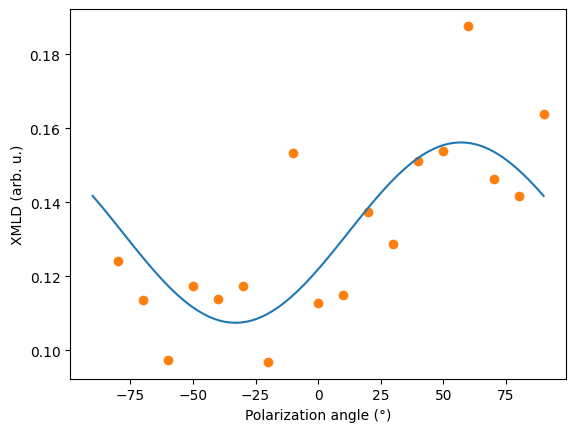

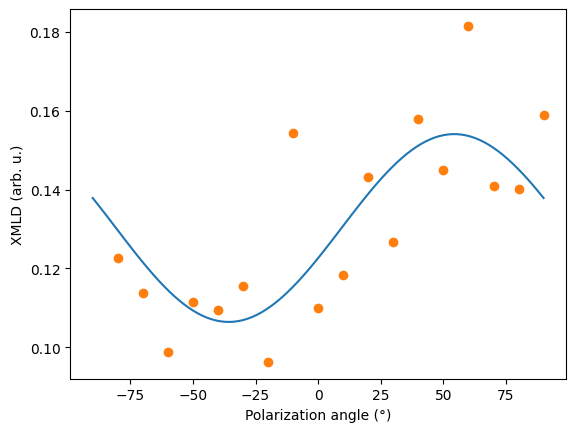

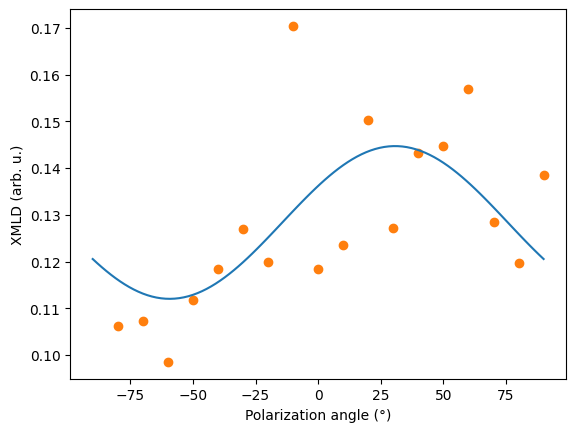

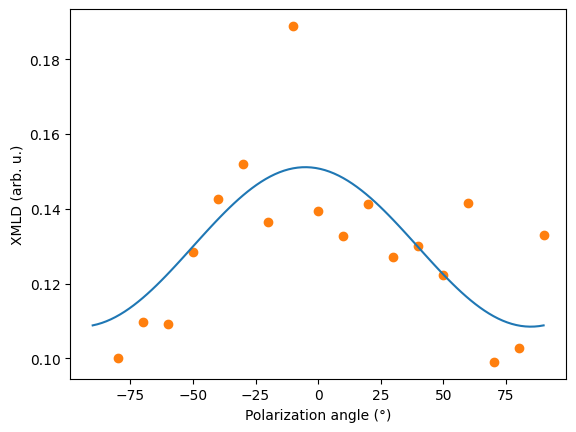

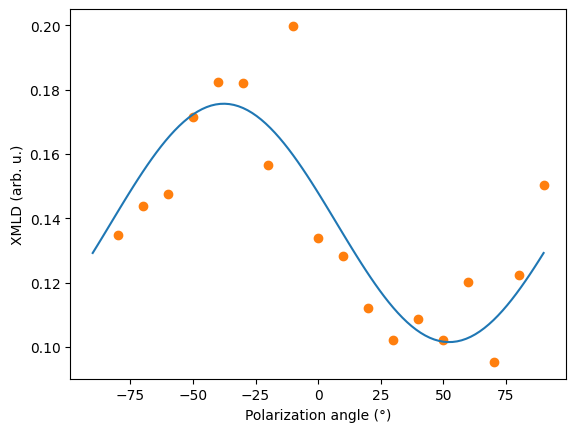

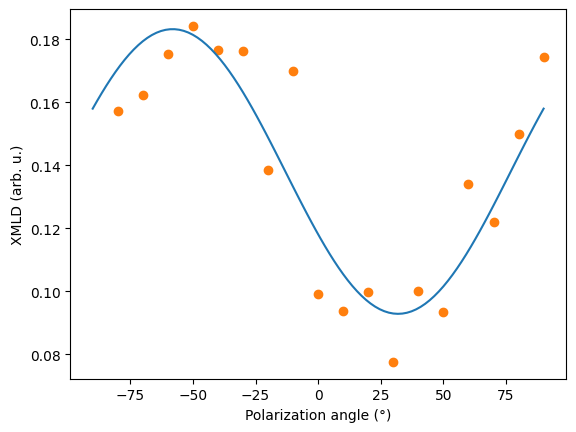

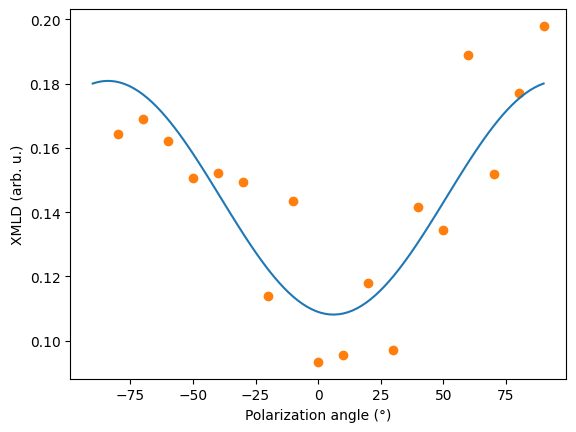

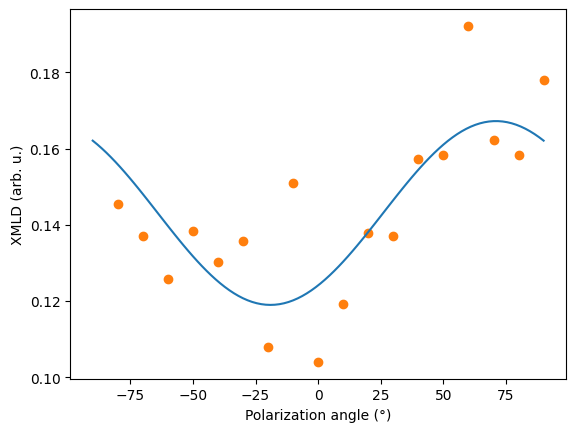

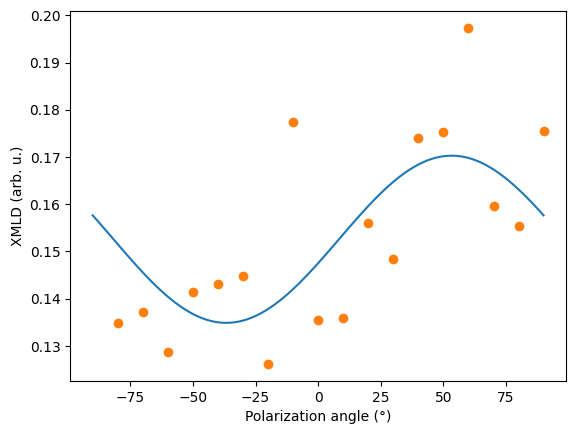

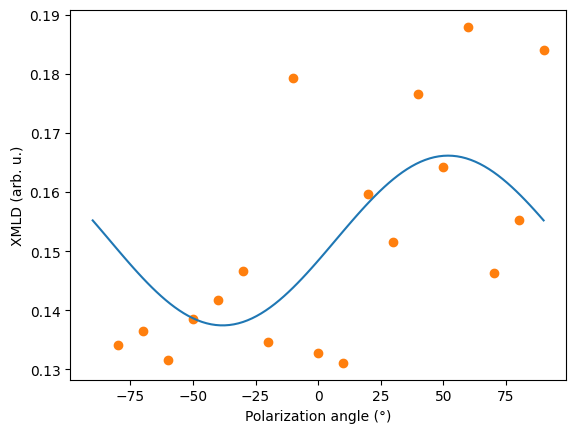

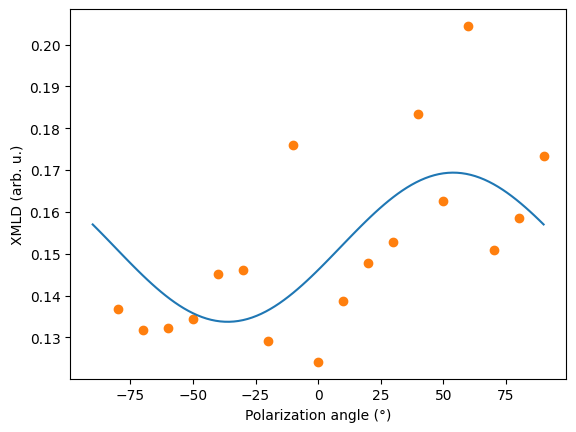

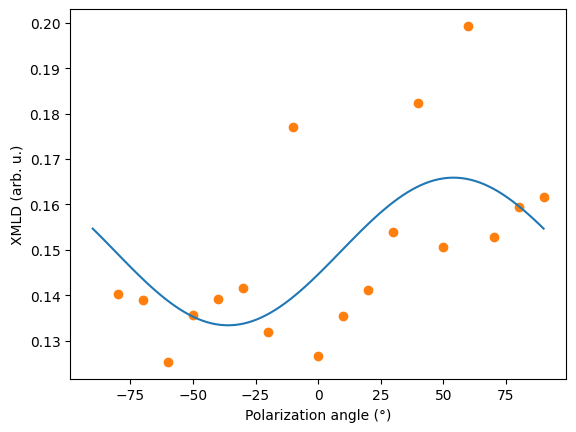

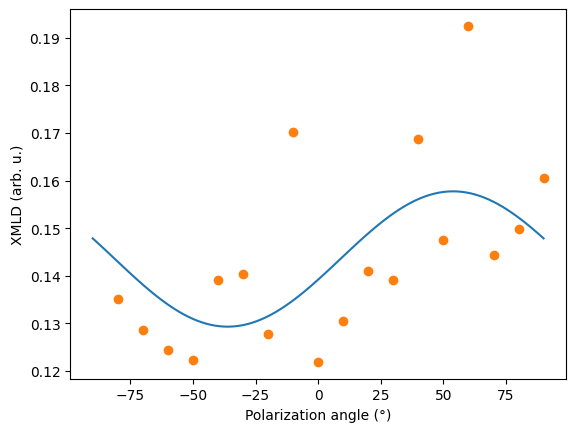

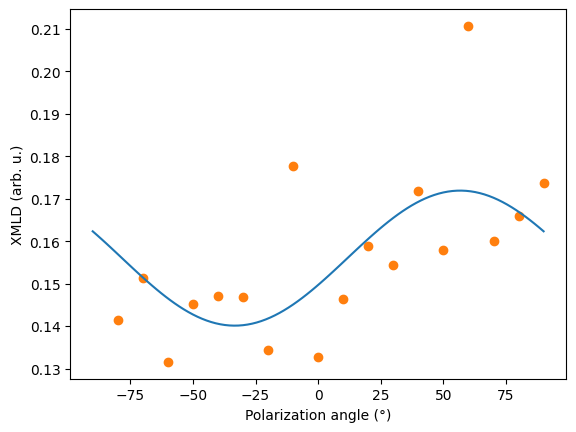

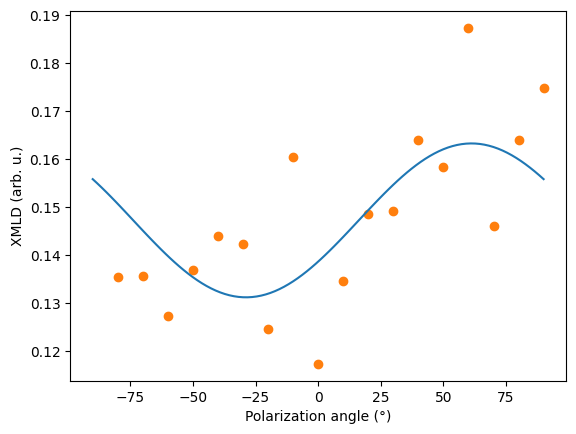

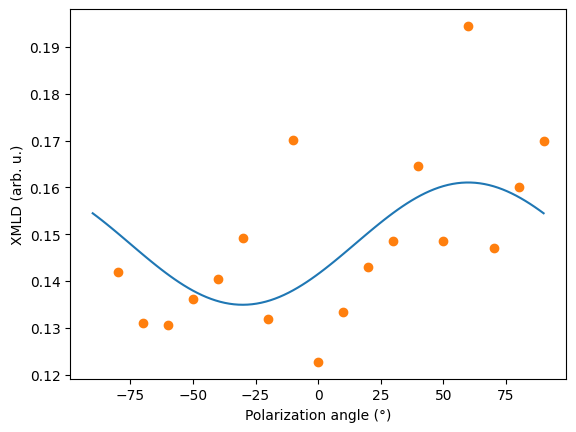

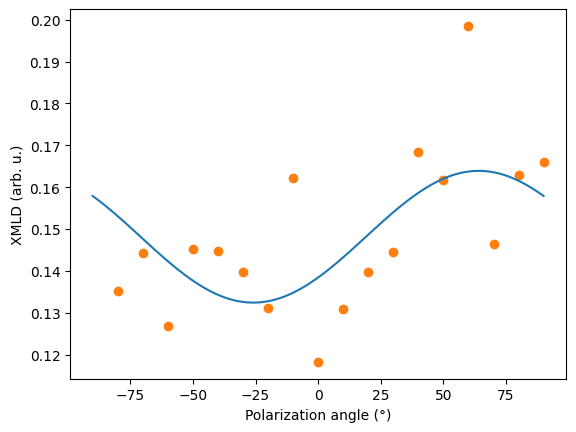

In [33]:

def sin2(x,theta,A,offset):
    return np.sin(np.deg2rad(x+theta))**2*A+offset

img_pixavg = np.array([
        skimage.transform.resize(image, resize) for image in xmld_stack_corrected])

for i in range(resize[0]):
    for j in range(resize[1]):
        if i+j == 5*j:
            intensity = img_pixavg[:,i,j]
            try:
                boundary = ([-90, 0, -np.inf],[90, np.inf, np.inf])
                popt, pcov = curve_fit(sin2, angles, intensity, bounds=boundary)
                perr = np.sqrt(np.diag(pcov))
            except: 
                popt = np.ones(3)*np.nan
                perr = np.ones(3)*100
    
            fig0,ax0 = plt.subplots()
            print(*popt)
            ax0.plot(angles,intensity,color='C1',marker='o',lw=0)
            ax0.plot(np.linspace(-90,90,100),sin2(np.linspace(-90,90,100),*popt))
            ax0.set_xlabel('Polarization angle (°)')
            ax0.set_ylabel('XMLD (arb. u.)')
            



In [ ]:
imagepath1= (basefolder+tiffilenames[1])
#image1 = cv2.cvtColor(basefolder+tiffilenames[0])
image1 = butils.read_tiff(imagepath1)#[256:-256,256:-256]
plt.imshow(image1, cmap = 'gray')#, vmin=-30,vmax= 35)
plt.show()
image1_bkgcorr = butils.slightly_smarter_background_correction(image1,n=2,edge_cutting_condition_factor=0.95)
image1_bkgcorr_norm = (image1_bkgcorr-np.min(image1_bkgcorr))/(np.max(image1_bkgcorr)-np.min(image1_bkgcorr))
print(np.max(image1_bkgcorr_norm),np.min(image1_bkgcorr_norm),np.shape(image1))
#plt.imshow(image1, vmin=80,vmax= 100)
plt.imshow(image1_bkgcorr_norm[50:-50,50:-50], cmap = 'gray')#, vmin=-30,vmax= 35)
plt.show()

imagepath2= (basefolder+tiffilenames[2])
#image1 = cv2.cvtColor(basefolder+tiffilenames[0])
image2 = butils.read_tiff(imagepath2)
image2_bkgcorr = butils.slightly_smarter_background_correction(image2,n=2,edge_cutting_condition_factor=0.95)
image2_bkgcorr_norm = (image2_bkgcorr-np.min(image2_bkgcorr))/(np.max(image2_bkgcorr)-np.min(image2_bkgcorr))
print(np.max(image2_bkgcorr_norm),np.min(image2_bkgcorr_norm))
#plt.imshow(image2, vmin=80,vmax= 100)
plt.imshow(image2_bkgcorr_norm[50:-50,50:-50], cmap = 'gray')#, vmin=-30,vmax= 35)
plt.show()
